# Choose a Car Profitably [Car Price prediction] PART.2

In this part we will focus on feature engineering and building a several models.
Reference: Car Price Prediction (the _A_Team) [Prt.2 EDA]

This work has made by Paul Krivchenia in cooperation with Vitaliy Burlakov (a.k.a Vetak8):

[My GitHub](https://github.com/Paull-dark)

[Vetak's GitHub](https://github.com/vetak8)

[Vetak's Kaggle](https://www.kaggle.com/vitaliyburlakov)

<img src = 'http://3.bp.blogspot.com/--knDCWYzMOw/UqzpwyctJeI/AAAAAAAAAT8/Ui66KNd1nXM/s1600/7egylh57hbhs.jpg' width= '400px'>

<a id="sec2"></a>
# [1. INDEX](#sec1)

<a id="sec1"></a>
1. [INDEX](#sec1)
2. [IMPORT LIBRARRIES](#sec2)
3. [Functions and Classes](#sec3)
    * [3.1 General Functions](#sec3.1)
    * [3.2 Classes](#sec3.2)
    * [3.3 Functions for feature engineering](#sec3.3)
4. [Load and Chek the Dataset](#sec4)
5. [Feature Engeneering](#sec5)
    * [5.1 Target](#sec5.1)
    * [5.2 Body_type & Model_name](#sec5.2)
    * [5.3 Color](#sec5.3)
    * [5.4 Model_name](#sec5.4)
    * [5.5 Description](#sec5.5)
    * [5.6 Equipment dict](#sec5.6)
    * [5.7 Fuel_type](#sec5.7)
    * [5.8 Mileage](#sec5.8)
    * [5.9 Engine displacement](#sec5.9)
    * [5.10 Engine Power](#sec5.10)
    * [5.11 Super Gen](#sec5.11)
    * [5.12 Wheel Drive](#sec5.12)
    * [5.13 Price drop index](#sec5.13)
    * [5.14 Dropping cols without content](#sec5.14)
    * [5.15 Vendor](#sec5.15)
    * [5.16 Handling multocorrelation out](#sec5.16)
    * [5.17 Clustering](#sec5.17)
    * [5.18 Log Func](#sec5.18)
    * [5.19 Encoding](#sec5.19)
    * [5.20 Dropping columns out](#sec5.20)
6. [Prepare the data for models](#sec6)

<a id="sec2"></a>
# [2. Import LIBRARIES](#sec2)

In [1]:
from Preprocessing import df_combined

import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import statsmodels.api as sm
import ast
import warnings
from jupyterthemes import jtplot

from textblob import TextBlob  # for sentiment analysis
from wordcloud import WordCloud, STOPWORDS  # for creating cloud of words
from sklearn.cluster import DBSCAN

from sklearn.decomposition import PCA 
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_selection import f_regression
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV


from lazypredict.Supervised import LazyRegressor
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import ElasticNet
from xgboost import XGBRFRegressor
from catboost import CatBoostRegressor
import xgboost as xgb
import lightgbm  as lgb
import lightgbm
import optuna


from xgboost import plot_importance

warnings.filterwarnings("ignore")

%matplotlib inline
pd.set_option('display.max_rows', 50)  # Show more rows
pd.set_option('display.max_columns', 50)  # Show more columns
plt.style.use('ggplot')  # Nice plotting

jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)


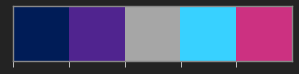

In [2]:
# Set project colors
colors = ['#001c57', '#50248f', '#a6a6a6', '#38d1ff','#cc3181']
sns.palplot(sns.color_palette(colors))

<a id="sec3"></a>
# [3. Functions and Classes](#sec3)
[(INDEX)](#sec1)

<a id="sec3.1"></a>
## [3.1 GENERAL FUNCTIONS](#sec3.1)
[(INDEX)](#sec1)

In [3]:
def missing_vars(data, column, random_proba=True):
    '''Function is called for filling of missing data'''
    # With using probability and random choise

    if random_proba:
        col_name = data[column].value_counts().index.to_list(
        )  # get list of values
        col_distr = data[column].value_counts(
            normalize=True).values  # get l;ist of probs
        missing = data[col].isnull()  # flag of missing val
        # substitute values from the list of names in accordance with the probability of meeting the name
        data.loc[missing, [column]] = np.random.choice(col_name,
                                                    size=len(data[missing]),
                                                    p=col_distr)

    # Using  most common in  column
    data[col] = data[col].fillna(data[col].value_counts().index[0])

In [4]:
def get_variable_distribution(col, title=None):
    '''Function is called to plot feture distribution'''

    title = title if title is not None else f"Distribution for '{col}"
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5),)
    fig = sm.qqplot(col, fit=True, line='45', ax=ax1)
    fig.suptitle(title, fontsize=20)

    sns.distplot(col.values, bins=20, color=colors[1], ax=ax2)
#     sns.violinplot(col.values, color=colors[3], bw=.3, cut=1, linewidth=4)
    sns.boxplot(col.values,color=colors[3])

    ax1.set_title('QQ-plot')
    ax2.set_title('Distribution')
    ax3.set_title('Boxplot')

    plt.show()

In [5]:
def corr_matrix(data, det=True, pltx=10, plty=10):
    '''Funcion is called for making correlation matrix'''

    corr = data.corr()
    if det:

        evals, evec = np.linalg.eig(corr)
        ev_product = np.prod(evals)

        print(f'Rank of Matrix: {np.linalg.matrix_rank(corr)}')
        print(f'Determinant of matrix: {np.round(ev_product,4)}')
        print(f'Shape of matrix: {np.shape(corr)}')

    plt.figure(figsize=(pltx, plty))
    sns.heatmap(corr[(corr >= .2) | (corr <= -.2)],
                cmap='viridis',
                vmin=-1.0,
                linewidths=0.1,
                annot=True,
                annot_kws={"size": 10},
                square=True)
    #     sns.heatmap(X,vmin=0,vmax=.9,annot=True,square=True)
    plt.show()

In [6]:
def cleanTxt(text):
    '''Function is called for cleaning text from trash
    INPUT: dirty string
    OUTPUT: More or less clean string'''

    text = re.sub(r'@[А-Яа-я0-9]+', '', text)  # Remove @
    text = re.sub(r'#', '', text)  # remove #
    text = re.sub(r'{', '', text)
    text = re.sub(r'}', '', text)
    text = re.sub('^а-яА-Я', ' ', text)
    text = re.sub(r'https?:\/\/\S+', '', text)  # remove hyperlink
    text = re.sub(r'\n', '', text)
    text = re.sub(r'✅', '', text)
    text = re.sub(r'👍🏻', '', text)
    text = re.sub(r'✨', '', text)
    
    
    # there are much more emoji. I don't know how to identify them so far

    text = text.strip()
    text = text.lower()
    #text = text.split()
    return text

In [7]:
def to_log(df, cols_to_log):
    'smart log'
    for col in cols_to_log:
        a = df[col].min()
        if a <= 0:                        
            df[col] = np.log(df[col] + (int(abs(df[col].min()))+2))
        
        df[col] = np.log(df[col])
    return df

In [8]:
# Defining MAPE function since it was removed from sklearn
def mape(y_true, y_pred):
    'Function to calculate MAPE metric'
#     y_true, y_pred = np.expm1(y_true), np.expm1(y_pred)
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true) * 100)

In [9]:
def get_regression_metrics(report_df,y_true, y_pred, name):
    '''Create and add metrics into a pandas DF after experiment'''
    y_true, y_pred = np.expm1(y_true), np.expm1(y_pred)

    report = pd.DataFrame(columns={'MAPE'}, data=[0])
    try:
        report['MAPE'] = mape(y_true, y_pred)
    except:
        report['MAPE'] = 'failed'
    report['MAE'] = mean_absolute_error(y_true, y_pred)
    report['MSE'] = mean_squared_error(y_true, y_pred)
    report['RMSE'] = np.sqrt(mean_squared_error(y_true, y_pred))

    report.index = [name]
    report_df = report_df.append(report)
    return report_df

<a id="sec3.2"></a>
## [3.2 Classes](#sec3.2)
[(INDEX)](#sec1)

In [10]:
class Encoder():
    def __init__(self, dataframe):
        self.dataframe = dataframe

    def label_encoder(self, column):
        '''Method is called for label encoding'''
        le = LabelEncoder()
        self.dataframe[column] = le.fit_transform(self.dataframe[column])

    def hot_encoder(self, column):
        '''Method is calling for hot encoding'''
        ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)
        aux_df = pd.DataFrame(ohe.fit_transform(self.dataframe[[column]]))
        aux_df.columns = ohe.get_feature_names([f'hot_{column}'])
        self.dataframe = self.dataframe.drop(col, axis=1)
        self.dataframe = pd.concat([self.dataframe, aux_df], axis=1)
        return self.dataframe

In [11]:
class Outliers_detector():
    def __init__(self, df):
        self.df = df

    def get_IQR_outliers(self, column):
        '''Method is called to detect IQR outliers'''
        outliers = dict()
        q1, q3 = np.percentile(sorted(self.df[column]), [25, 75])

        IQR = q3 - q1

        l_b = q1 - (1.5 * IQR)  # lower bound
        u_b = q3 + (1.5 * IQR)  # upper bound
        outl_count = len(self.df[column][self.df[column] < l_b]) + len(
            self.df[column][self.df[column] > u_b])

        outliers['lower_bound'] = round(l_b, 3)
        outliers['upper_bound'] = round(u_b, 3)
        outliers['outlier_count'] = outl_count

        return outliers

    def get_dbscan_outliers(self, column1, column2, dbscan_eps,
                            dbscan_minsample, cluster_num):
        '''Method is called for detecting outliers for two columns by dbscan'''

        scaler = RobustScaler()
        scale_column1 = scaler.fit_transform(pd.DataFrame(
            self.df[column1])).reshape(1, -1)[0]
        scale_column2 = scaler.fit_transform(pd.DataFrame(
            self.df[column2])).reshape(1, -1)[0]
        df_temp = pd.DataFrame({
            'column1': scale_column1,
            'column2': scale_column2
        })
        clustering = DBSCAN(eps=dbscan_eps,
                            min_samples=dbscan_minsample).fit(df_temp.values)
        df_temp["cluster"] = clustering.labels_
        df_temp.index = self.df.index
        fig = px.scatter(self.df,
                   x=scale_column1,
                   y=scale_column2,
                   color=clustering.labels_,
                   size=column2)
        # Edit the layout
        fig.update_layout(title='Detected Custers\n')
        fig.update_xaxes(title=(f'{column1}'))
        fig.update_yaxes(title=(f'{column2}'))
        fig.update_layout(width = 700)
        fig.update_layout(height = 600)
        
        fig.show()
        #         sns.scatterplot(scale_column1, scale_column2,
        #                         hue=clustering.labels_, alpha=0.5)
        #         plt.title('CLUSTERS\n', fontsize=15)
        #         plt.xlabel(f'{column1}')
        #         plt.ylabel(f'{column2}')
        return df_temp[df_temp["cluster"] == cluster_num].index

<a id="sec3.3"></a>
## [3.3 FUNCTIONS FOR FEATURE ENGINEERING](#sec3.3)
[(INDEX)](#sec1)

In [12]:
def get_tax_category(engine_power):
    '''Function breaks down the number of horse
    power by taxation category in Russia'''

    if engine_power <= 100:
        return int(1)
    elif 100 < engine_power <= 150:
        return int(2)
    elif 150 < engine_power <= 200:
        return int(3)
    elif 200 < engine_power <= 250:
        return int(4)
    elif engine_power > 250:
        return int(5)


def get_low_registr(word):
    '''Get lowercase for string'''
    try:
        return word.lower()
    except:
        return None
    
def get_i3_displacement(engine_displacement, fuel_type, model_name):
    '''fill mising values for  BMW i3'''
    
    if model_name == 'i3':
        if fuel_type == 'hybrid':
            return 0.7
        else:
            return 0
    else:
        return engine_displacement

def get_electro_displacement(engine_displacement, fuel_type):
    '''Filling mising vars for electrocars'''
    
    if fuel_type == 'electro':
        return 0
    else:
        return engine_displacement
    
def get_acceleration(string):
    '''Function extracting acceleration'''
    
    try:
        return float(re.split(',', re.split('acceleration\W+', str(string))[1])[0])
    except:
        return None
    
def get_fuel_rate(string):
    '''Extrating fuel rate'''
    try:
        return float(re.split(',', re.split('fuel_rate\W+', str(string))[1])[0])

    except:
        return None

<a id="sec4"></a>
# [4.Load and Chek the Dataset](#sec4)
[(INDEX)](#sec1)

In [13]:
# import data pre-processed data set
df = df_combined.copy()
df.sample(2)

,body_type,brand,color,complectation_dict,description,engine_displacement,engine_power,equipment_dict,fuel_type,image,mileage,model_date,model_info,model_name,name,doors_count,price_currency,production_date,sell_id,super_gen,vehicle_configuration,vehicle_transmission,vendor,owner_count,owning_period,car_passport,wheel_drive,wheel_location,condition,custom,price,sample
36260,седан,BMW,синий,{'id': '0'},По технике автомобиль в очень хорошем состояни...,2.00,150.00,{'alloy-wheel-disks': True},бензин,NaN,450000,1987,"{'code': '5ER', 'name': '5 серии', 'ru_name': ...",5ER,520i 2.0 MT (150 л.с.),4,RUB,1994,1103326916,"{'id': '21268458', 'name': '520', 'nameplate':...",useless_col,MECHANICAL,EUROPEAN,3,NaN,DUPLICATE,задний,LEFT,True,True,210000.00,1
21980,внедорожник 5 дв,TOYOTA,белый,NaN,Бережная эксплуатация. Крашеных деталей нет. О...,3.00,173.00,NaN,дизель,https://autoru.naydex.net/imflT9272/520f62I9/2...,160000,2009,"{""code"":""LAND_CRUISER_PRADO"",""name"":""Land Crui...",LAND_CRUISER_PRADO,3.0d AT (173 л.с.) 4WD,5,RUB,2010,1100975988,"{""id"":""6020187"",""displacement"":2982,""engine_ty...",ALLROAD_5_DOORS AUTOMATIC 3.0,AUTOMATIC,JAPANESE,2,9 лет и 2 месяца,ORIGINAL,полный,LEFT,Не требует ремонта,Растаможен,nan,0


<a id="sec5"></a>
# [5. Feature Engeneering](#sec5)
[(INDEX)](#sec1)

Get lowercase for all unpreceed columns

In [14]:
# take cols with objects
object_columns = df.dtypes[df.dtypes.values == object].index.to_list()

for col in object_columns:
    df[col] = df[col].apply(lambda string: get_low_registr(string))

<a id="sec5.1"></a>
## [Target](#sec5.1)
[(INDEX)](#sec1)

As our dataset includes combined train & test stes, and test set contains 

Nan values in price column, let's extract only train part for a minute and process it 

In [15]:
# Defining features and target
X_train = df[df['sample'] == 1]

X_test = df[df['sample'] == 0]

In [16]:
# idx_to_drop = list(X_train[X_train['price'] >= 30000000].index)
# X_train=X_train.drop(idx_to_drop)

NOTE: Dropping outliers has bad impact on MAPE. Comment above cell

Scraped data has missing values in price column. Drop these rows:

In [17]:
X_train['price'].isna().sum()

624

In [18]:
indexes_to_drop = X_train[(df['price'].isna())].index
X_train = X_train.drop(indexes_to_drop)

With a reference to EDA, we remember that target is not normally distributed.

Let's apply logarithm to it and see what will happen

In [19]:
X_train['price']= np.log(X_train['price'])

Text(0.5, 0, 'Price')

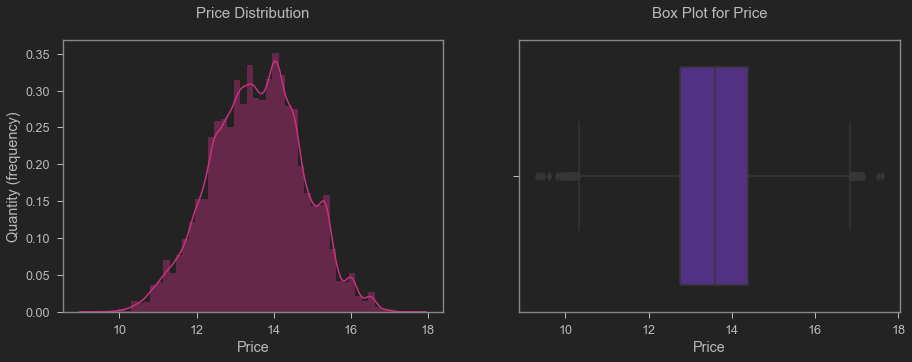

In [20]:
plt.figure(figsize=(15, 5))
plt.subplot(121)
sns.distplot(X_train.price.values, bins=50, color=colors[4])
plt.title('Price Distribution\n', fontsize=15)
plt.xlabel('Price')
plt.ylabel('Quantity (frequency)')

plt.subplot(122)
sns.boxplot(X_train.price.values, color=colors[1])
plt.title('Box Plot for Price\n', fontsize=15)
plt.xlabel('Price')

Looks better.
Let's again combine datasets for further engineering

In [21]:
# combine sets
df = X_train.append(X_test, sort=False).reset_index(drop=True)

<a id="sec5.2"></a>
## [5.2 body_type & Model_name](#sec5.2)
[(INDEX)](#sec1)

As we have quite a lot of brands in data set, and especially lot's of models,

let's generate new feature for each of mentioned model and brand by taking mean price of each model/brand

In [22]:
cols_to_process = ['model_name', 'brand', 'body_type']
for col in cols_to_process:
    col_mean_dict = df.groupby([col])['price'].mean().to_dict()
    df[f'priced_{col}'] = df[col].apply(lambda x: col_mean_dict[x])

We remember (EDA) that models number mismatch in train and test set.

So our new feature definately will have missing vars. Let's fix it by filling it with median

In [23]:
df['priced_model_name'].isna().sum()

17

In [24]:
df['priced_model_name'] = df['priced_model_name'].fillna(df['priced_model_name'].median())

Reduce quantity of body_types

In [25]:
pattern = re.compile('[а-я]*')
new_column = []
for string in df['body_type']:
    new_column.append(pattern.match(str(string))[0])
df['body_type'] = new_column

In [26]:
# Create list with top body types
top_colors = df['body_type'].value_counts()[df['body_type'].value_counts(
) > np.percentile((df['body_type'].value_counts().values), 70)].index.tolist()

#take all bodies from df to a list
all_colors = df['body_type'].value_counts().index

# Identify, what to delete
colors_to_drop = set(all_colors) - set(top_colors)

# Make replacemewnt
df.loc[df['body_type'].isin(colors_to_drop), 'body_type'] = 'other'

In [27]:
df['body_type'].value_counts()

седан          66649
внедорожник    63984
хэтчбек        16791
other          14990
лифтбек         9291
универсал       7030
Name: body_type, dtype: int64

Translate it to english. (for some reason, LightGBM doesn't work with russian column names)

In [28]:
body_type_dict = dict({
    'седан':'sedan',
    'внедорожник':'4wd',
    'хэтчбек':'hachtback',
    'other':'other',
    'лифтбек':'liftback',
    'универсал':'universal'
})
df['body_type'] = df['body_type'].map(body_type_dict)

In [29]:
df.body_type.unique()

array(['sedan', 'universal', 'other', '4wd', 'hachtback', 'liftback'],
      dtype=object)

Fine, we reduced number of body_types and translated it in to English

<a id="sec5.2"></a>
## [5.3 Color](#sec5.2)
[(INDEX)](#sec1)

NOTE: After some experiments, it was decided to do not include this column in to a model. Bad impact on MAPE

With a reference to EDA section we generate new feature to show whether the color is popular.

Meanwhile we re-orgasnize colors in original column by taking only most common colors

In [30]:
# # List of top3 colors (see EDA)
# # Has no impact
# popular_color = ['чёрный', 'белый', 'серый']
# df['popular_color'] = df['color'].apply(
#     lambda color: 1 if color in popular_color else 0)

In [31]:
# # Create list with top colors
# # Has no impact
# top_colors = df['color'].value_counts()[df['color'].value_counts(
# ) > np.percentile((df['color'].value_counts().values), 80)].index.tolist()

# #take all colors from df to a list
# all_colors = df['color'].value_counts().index

# # Identify, what to delete
# colors_to_drop = set(all_colors) - set(top_colors)

# # Make replacemewnt
# df.loc[df['color'].isin(colors_to_drop), 'color'] = 'other'

In [32]:
# df['color'].unique()

In [33]:
# color_dict = dict({
#     #'синий':'blue',
#     'чёрный':'black',
#     'серый':'gray',
#     'other':'other',
#     'белый':'white',
#     #'серебристый':'silver'
# })
# df['color'] = df['color'].map(color_dict)

<a id="sec5.4"></a>
## [5.4 Model_name](#sec5.4)
[(INDEX)](#sec1)

NOTE: Already proceed above

<a id="sec5.5"></a>
## [5.5 Description](#sec5.5)
[(INDEX)](#sec1)

Let's generate new features:
- Sensitivity and polarity of each description in a column;
- Extract keywords from description

In [34]:
df['description'] = df['description'].fillna('none')
df['description'] = df['description'].apply(cleanTxt)
df['description'] = df['description'].apply(lambda x : x.lower())

In [35]:
# Create a function to get the subjectivity
def get_subjectivity(text):
    return TextBlob(text).sentiment.subjectivity


# Create a function to get the polarity
def get_polarity(text):
    return TextBlob(text).sentiment.polarity

In [36]:
# Create new cols and call the func

df['subjectivity'] = df['description'].apply(get_subjectivity)

df['polarity'] = df['description'].apply(get_polarity)

In [37]:
%%script false
# Note: useless insight. Do not include in the final set
# Create a function to compute the negative, neutral and positive analysis
def get_analysis(score):
    if score < 0:
        return 'negative'
    elif score == 0:
        return 'neutral'
    else:
        return 'positive'

Couldn't find program: 'false'


In [38]:
%%script false
# Has no impact
df['analysis'] = df['polarity'].apply(get_analysis)

Couldn't find program: 'false'


With a reference to EDA (Sentiment section), let's check plot of worldcloud and generate new features. 

If description has specified keyword, the we add 1 to new column

In [39]:
df['airbags'] = df['description'].apply(
    lambda x: 1 if 'подушки безопасности' in x else 0)
df['cruise'] = df['description'].apply(
    lambda x: 1 if 'круиз' in x else 0)
df['steering'] = df['description'].apply(
    lambda x: 1 if 'усилитель руля' in x else 0)
df['loan'] = df['description'].apply(
    lambda x: 1 if 'кредит' in x else 0)
df['anti_block'] = df['description'].apply(
    lambda x: 1 if 'антиблокировочная' in x else 0)
df['lock'] = df['description'].apply(
    lambda x: 1 if 'центральный замок' in x else 0)
df['climat'] = df['description'].apply(
    lambda x: 1 if 'климат контроль' in x else 0)
df['rain_sens'] = df['description'].apply(
    lambda x: 1 if 'датчик дождя' in x else 0)

In [40]:
# show data
df.sample(4)

,body_type,brand,color,complectation_dict,description,engine_displacement,engine_power,equipment_dict,fuel_type,image,mileage,model_date,model_info,model_name,name,doors_count,price_currency,production_date,sell_id,super_gen,vehicle_configuration,vehicle_transmission,vendor,owner_count,owning_period,car_passport,wheel_drive,wheel_location,condition,custom,price,sample,priced_model_name,priced_brand,priced_body_type,subjectivity,polarity,airbags,cruise,steering,loan,anti_block,lock,climat,rain_sens
45518,4wd,mercedes,чёрный,{'id': '0'},автомобиль приобретен на юридическое лицо. юри...,4.00,585.00,{},бензин,//avatars.mds.yandex.net/get-autoru-vos/196497...,43439,2018,"{'code': 'g_klasse_amg', 'name': 'g-класс amg'...",g_klasse_amg,63 amg 4.0 at (585 л.с.) 4wd,5,rub,2020,1103435232,"{'id': '21203530', 'name': '63 amg', 'nameplat...",useless_col,automatic,european,1,None,original,полный,left,None,None,16.71,1,16.13,14.37,14.36,0.00,0.00,0,0,0,1,0,0,0,0
172466,sedan,mitsubishi,чёрный,None,ремень грм помпа был заменён на 150т км 2000т...,1.60,98.00,None,бензин,https://autoru.naydex.net/mcqh17801/f1b5751dci...,176500,2005,"{""code"":""lancer"",""name"":""lancer"",""ru_name"":""ла...",lancer,1.6 at (98 л.с.),4,rub,2005,1100457340,"{""id"":""3480641"",""displacement"":1584,""engine_ty...",sedan automatic 1.6,automatic,japanese,3,None,original,передний,left,не требует ремонта,растаможен,nan,0,12.57,13.21,13.10,0.00,0.00,0,0,0,0,0,0,0,0
33887,4wd,nissan,серебристый,{'id': '0'},.куплена официального дилера 08.2016обслужива...,2.50,171.00,"{'cruise-control': true, 'engine-proof': true,...",бензин,//avatars.mds.yandex.net/get-autoru-vos/458170...,101000,2013,"{'code': 'x_trail', 'name': 'x-trail', 'ru_nam...",x_trail,2.5 cvt (171 л.с.) 4wd,5,rub,2015,1103125262,"{'id': '20416563', 'displacement': 2488, 'engi...",useless_col,variator,japanese,1,None,original,полный,left,None,None,14.21,1,14.16,13.10,14.36,0.00,0.00,0,0,0,1,0,0,0,0
65290,sedan,audi,чёрный,{'id': '0'},none,1.80,120.00,{},бензин,//avatars.mds.yandex.net/get-autoru-vos/436552...,285000,2007,"{'code': 'a4', 'name': 'a4', 'ru_name': 'а4', ...",a4,1.8 cvt (120 л.с.),4,rub,2008,1103643961,"{'id': '4693252', 'displacement': 1798, 'engin...",useless_col,variator,european,1,"{'year': 2021, 'month': 1}",original,передний,left,None,None,13.38,1,13.66,13.76,13.10,0.00,0.00,0,0,0,0,0,0,0,0


<a id="sec5.6"></a>
## [5.6 Equipment Dict](#sec5.6)
[(INDEX)](#sec1)

Let's exctrat the number of equipments listed in the subjected column

In [41]:
df['equipment_dict'].isna().sum()

9996

First of all, fill up missing values in the column

In [42]:
def fill_empty_equipment(model, dict_):
    if dict_=={}:
        return tipical_equipment_dict[model]
    return dict_

In [43]:
def fill_na_equip_lenght(model_name,value):
    if value==0:
        return int(mean_equip_lenhgt_dict[model_name])
    return value

In [44]:
df['equipment_dict'] = df['equipment_dict'].str.replace('\"', '\'').str.replace(
    ' ', '').str.replace(':t', ':T')  #  General view
df['equipment_dict'] = df['equipment_dict'].apply(lambda string: {} if pd.isna(
    string) else ast.literal_eval(string))  # transform string to dicts

In [45]:
# The idea is to create a dictionary: the most complete set of
# cars, then fill in the gaps with this dictionary
model_names = df['model_name'].unique()
tipical_equipment_dict = dict.fromkeys(model_names)
for model in model_names[:]:
    max_len = 0
    for dict_ in df[df['model_name'] ==
                    model]['equipment_dict'].value_counts().index:
        tipical_equipment_dict.update({model: dict_})
        if len(dict_) > max_len:
            tipical_equipment_dict.update({model: dict_})

In [46]:
df['equipment_dict'] = df[['model_name', 'equipment_dict']].apply(
    lambda x: fill_empty_equipment(*x), axis=1)

In [47]:
df['equipment_length'] = df['equipment_dict'].apply(lambda dict_: len(dict_))

mean_equip_lenhgt_dict = df.groupby('model_name')['equipment_length'].mean(
).round().to_dict()  # Словарь с среднимим значениями длин словарей экипировки

df['equipment_length'] = df[['model_name', 'equipment_length'
                             ]].apply(lambda x: fill_na_equip_lenght(*x),
                                      axis=1)  # filling

In [48]:
# Check if dictionaries contain False 
count_false=0
for dict_ in df['equipment_dict']:
    for i in dict_:
        if dict_[i]==False:
            count_false+=1
count_false

0

The length of the equipment_dict characterizes the number of functions in the auto 

In [49]:
# df[df['equipment_dict']=={}]['model_name'].unique()

In [50]:
# # Создадим множество всех атрибутов в авто
# attributes = set()
# for dict_ in df['equipment_dict']:    
#     attributes.update(dict_.keys())

In [51]:
# dv = DictVectorizer()
# equipment_features = dv.fit_transform(
#     df.query('sample==1')['equipment_dict']).toarray()
# equipment_df = pd.DataFrame(equipment_features, columns=dv.get_feature_names())
# equipment_attributes = equipment_df.columns.values

In [52]:
# f_scores, p_values = f_regression(equipment_df, df.query('sample==1')['price'])

In [53]:
# # Visualizing 50 best equipment features
# plt.figure(figsize=(20, 10))
# f_scores = pd.Series(f_scores, equipment_attributes).sort_values(ascending=False)
# best_attributes = f_scores[:50].index
# f_scores[:50].plot(kind='barh', color='green')
# plt.xlabel('F-Score')
# plt.title('50 best equipment features', size=16);

In [54]:
# 25% самых важных атрибутов в авто
# f_scores[f_scores.values > f_scores.values.max()*0.75]

In [55]:
# most_important_attributes = set(f_scores[f_scores.values > f_scores.values.max(
# )*0.75].index)  # Множество самых важных атрибутов

In [56]:
# def has_important_equipment(dict_):
#     # Проверка на принадлежность важнейших атрибутов атрибутам авто
#     if most_important_attributes.issubset(set(dict_.keys())):
#         return 1
#     return 0

In [57]:
# df['has_important_attrs'] = df['equipment_dict'].apply(
#     lambda x: has_important_equipment(x))

In [58]:
# df['has_important_attrs'].value_counts()

<a id="sec5.7"></a>
## [5.7 Fuel Type](#sec5.7)
[(INDEX)](#sec1)

In [59]:
# lets strip fuel type
df['fuel_type'] = df.fuel_type.apply(lambda fuel: str(fuel).strip())

In [60]:
fuel_type_dict = dict({
    'бензин':'benzin',
    'дизель':'dizel',
    'гибрид':'hybrid',
    'электро':'electro',
    'газ':'gas'
})

df['fuel_type'] = df['fuel_type'].map(fuel_type_dict)

<a id="sec5.8"></a>
## [5.8 Mileage](#sec5.8)
[(INDEX)](#sec1)

With  a reference to EDA section (plot numerical distribution), outcomes, we remember, that some cars has milage = 0 which is incorrect or unlogical. Fix it here

Save information where mileage was equal to zero 

NOTE: Has no impact on MAPE

In [61]:
#df['mileage_zero'] = df['mileage'].apply(lambda x: 1 if x == 0 else 0)

<a id="sec5.9"></a>
## [5.9 Engine Displacement](#sec5.9)
[(INDEX)](#sec1)

We know, that there is no engine displacement for the electical cars. We also know there is missing values in this colums.

Let's fix it. If car is electric - diplacement shall be 0.

In [62]:
df['engine_displacement'] = df[['engine_displacement','fuel_type']].apply(
    lambda x: get_electro_displacement(*x), axis=1)

It was observed that BMW model i3 has missing values in engine displacement. 

Let's say if it is a hybrid - then eng_displ - 0.7. If not - then 0

In [63]:
df['engine_displacement'] = df[[
    'engine_displacement', 'fuel_type', 'model_name'
]].apply(lambda x: get_i3_displacement(*x), axis=1)

<a id="sec5.10"></a>
## [5.10 Engine Power](#sec5.10)
[(INDEX)](#sec1)

There is a special low in Russian Federation that devide cars by tax categories. 

More power in engine, higer grade of tax. It may impact on a prediction. Let's break our cars down by such categories

In [64]:
# No impact on MAPE
# df['tax_rate'] = df['engine_power'].apply(
#     lambda engine_power: get_tax_category(engine_power)).astype('category')

In [65]:
# Fill up for 3 missing cars (civic)
df['engine_power'] = df['engine_power'].fillna(100) # CIVIC

In [66]:
# Break engine power by intervals
bins = [10, 35, 100, 125, 150, 175, 200, 225, 250, 801]
# Ctreate tax categories
numbers = ['5000', '12', '25', '35', '45', '50', '65', '75', '150']

In [67]:
# Make a column where refer each car depended by power to a tax cat
df['tax_base'] = pd.cut(df['engine_power'], bins, labels=numbers)
df['tax_base'] = df['tax_base'].values.astype('int64')

In [68]:
# generate tax fee col
df['tax'] = df['engine_power'] * df['tax_base']

<a id="sec5.11"></a>
## [5.11 Super Gen](#sec5.11)
[(INDEX)](#sec1)

Let's extract some information like an acceleration from supergen column.

Generate new feature Acceleration

In [69]:
# Before we do, fill up empty dictionaries with 'Nan'
df['super_gen'] = df['super_gen'].fillna('NaN')
df['super_gen'] = df['super_gen'].apply(cleanTxt)
# Extract fuel rate,acceleration and generate new feature
df['acceleration'] = df['super_gen'].apply(lambda string:get_acceleration(string))
df['fuel_rate'] = df['super_gen'].apply(lambda string:get_fuel_rate(string))

In [70]:
# missing vars in a new feature
df['acceleration'].isna().sum()

11243

In [71]:
df['fuel_rate'].isna().sum()

21408

Let's fill missing values by randomly choosen value from most common in particular colums.

For a company, add car pasport here and owner count

In [72]:
cols_to_fill = ['acceleration', 'fuel_rate', 'car_passport','owner_count']
for col in cols_to_fill:
    missing_vars(df,col)

<a id="sec5.12"></a>
## [5.12 Wheel Drive](#sec5.12)
[(INDEX)](#sec1)

In [73]:
# lets strip fuel type
df['wheel_drive'] = df.wheel_drive.apply(lambda drive: str(drive).strip())

In [74]:
drive_type_dict = dict({
    'передний': 'front',
    'полный': 'full',
    'задний': 'rear',
})

df['wheel_drive'] = df['wheel_drive'].map(drive_type_dict)

In [75]:
df[df['wheel_drive'].isna()]

,body_type,brand,color,complectation_dict,description,engine_displacement,engine_power,equipment_dict,fuel_type,image,mileage,model_date,model_info,model_name,name,doors_count,price_currency,production_date,sell_id,super_gen,vehicle_configuration,vehicle_transmission,vendor,owner_count,owning_period,car_passport,wheel_drive,wheel_location,condition,custom,price,sample,priced_model_name,priced_brand,priced_body_type,subjectivity,polarity,airbags,cruise,steering,loan,anti_block,lock,climat,rain_sens,equipment_length,tax_base,tax,acceleration,fuel_rate
56730,other,toyota,серебристый,"{'id': '0', 'name': ''}",авто в хорошем тех. состоянии..гаражное хранен...,nan,100.00,"{'engine-proof': True, 'cruise-control': True,...",NaN,//avatars.mds.yandex.net/get-autoru-vos/202337...,180000,1997,"{'code': 'noah', 'name': 'noah', 'ru_name': 'н...",noah,None,5,rub,2008,1092703248,nan,useless_col,None,japanese,3,None,original,NaN,right,None,None,13.44,1,13.35,13.47,12.25,0.00,0.00,0,0,0,0,0,0,0,0,38,12,1200.00,14.90,8.20
93719,other,honda,серебристый,"{'id': '0', 'name': ''}","продаю honda civic suttle 1989 г. выпуска, неу...",nan,100.00,"{'engine-proof': True, 'cruise-control': True,...",NaN,//avatars.mds.yandex.net/get-autoru-vos/216179...,400000,2006,"{'code': 'civic', 'name': 'civic', 'ru_name': ...",civic,None,4,rub,1989,1097454742,nan,useless_col,None,japanese,3,None,original,NaN,left,None,None,11.70,1,12.71,13.00,12.25,0.00,0.00,0,0,0,0,0,0,0,0,43,12,1200.00,6.90,6.80
94094,other,honda,пурпурный,"{'id': '0', 'name': ''}",в хорошем состоянии на ходу,nan,100.00,"{'engine-proof': True, 'cruise-control': True,...",NaN,//avatars.mds.yandex.net/get-autoru-vos/215360...,220000,2005,"{'code': 'civic', 'name': 'civic', 'ru_name': ...",civic,None,4,rub,1989,1096777604,nan,useless_col,None,japanese,3,None,original,NaN,left,None,None,11.61,1,12.71,13.00,12.25,0.00,0.00,0,0,0,0,0,0,0,0,43,12,1200.00,12.30,6.60


Civic. Fill With front

In [76]:
df['wheel_drive'] = df['wheel_drive'].fillna('front')

<a id="sec5.13"></a>
## [5.13 Price Drop Index](#sec5.13)
[(INDEX)](#sec1)

With a reference to EDA, we know, that some brands loose their price more faster than others. 

Let's generate such feature

In [77]:
def get_change_index(model):
    if model == 'ford':
        return int(1)
    if model == 'volvo' or model == 'mercedes':
        return int(2)
    if model == 'honda' or model == 'audi':
        return int(2)
    return int(0)

In [78]:
df['prc_chg_idx'] = df['brand'].apply(
    lambda brand: get_change_index(brand)).astype('category')

<a id="sec5.14"></a>
## [5.14 Dropping cols without content](#sec5.14)
[(INDEX)](#sec1)

In [79]:
df['engine_displacement'].isna().sum()

3

In [80]:
df = df.dropna(axis=0, subset=['engine_displacement'])

<a id="sec5.15"></a>
## [5.15 Vendor](#sec5.15)
[(INDEX)](#sec1)

During scraping of a dataset we gathered more vendors than were in a test data set. Let's replace those who are not in test dataset by 'Other'

Note: It was decided to not include this to a model

In [81]:
df['vendor'] = df['vendor'].apply(
    lambda x: x if x == 'european' else(x if x == 'japanese' else 'other'))

<a id="sec5.16"></a>
## [5.16 Handling multocorrelation out](#sec5.16)
[(INDEX)](#sec1)

In [82]:
# extract trhee columns from dataset, which are correlated
data = df[['mileage', 'model_date', 'production_date']].values
# create Scaler instance
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)

# We have 3 vectors. Reduce to two, taking most important info.
pca = PCA(n_components=2)
pca.fit(scaled_data)
pca_data = pca.transform(scaled_data)
df['pca_1'], df['pca_2'] = pca_data[:, 0], pca_data[:, 1]

<a id="sec5.17"></a>
## [5.17 Clustering](#sec5.17)
[(INDEX)](#sec1)

Note: I have failed to use clustering... :(

In [83]:
df_clus1 = df.copy()

In [84]:
# cluster = Outliers_detector(df_clus1)

In [85]:
# indeces = cluster.get_dbscan_outliers('production_date', 'engine_displacement', dbscan_eps=.4,
#                                      dbscan_minsample=12,
#                                      cluster_num=-1)
# print(f"Strange guys {len(indeces)}")

In [86]:
# Defining features and target
# X = df[df['sample'] == 1]

# X_test = df[df['sample'] == 0]

# print(f'X size: {X.shape}, X_testn size: {X_test.shape}')

In [87]:
# cluster = Outliers_detector(X)

In [88]:
# indeces = cluster.get_dbscan_outliers('model_date', 'price', dbscan_eps=.5,
#                                      dbscan_minsample=12,
#                                      cluster_num=-1)
# print(f"Strange guys {len(indeces)}")

In [89]:
# X=X.drop(indeces)
# X.reset_index(drop=True, inplace=True)

In [90]:
# df = X_test.append(X, sort=False).reset_index(drop=True)  # combine sets

<a id="sec5.18"></a>
## [5.18 Log Func](#sec5.18)
[(INDEX)](#sec1)

Try to make distribution normal for the propper fitting of the model 

In [91]:
cols_to_log = [
    'engine_displacement', 'mileage', 'model_date', 'production_date',
    'equipment_length', 'tax', 'acceleration', 'fuel_rate', 'pca_1', 'pca_2'
]

df = to_log(df, cols_to_log)

<a id="sec5.19"></a>
## [5.19 Encoding](#sec5.19)
[(INDEX)](#sec1)

After all manipulations with dataset, we have to reset indexes

In [92]:
# Re-set indexes
df.reset_index(drop=True, inplace=True)

In [93]:
encoder = Encoder(df)

In [94]:
to_hot = [
    #'body_type', # No impact
    #'brand', # No impact
    #'color', # No impact
    #'fuel_type',   # No impact
    #'doors_count', # No impact
    #'vehicle_transmission', # No impact
    'vendor',
    'wheel_drive',
    'owner_count',
]

to_label = [
    'car_passport', 'wheel_location', 'prc_chg_idx', 'vehicle_transmission'
]

In [95]:
# hot it out
for col in to_hot:
    df = encoder.hot_encoder(col)

In [96]:
# label it
for col in to_label:
    encoder.label_encoder(col)

<a id="sec5.20"></a>
## [5.20 Dropping columns out](#sec5.20)
[(INDEX)](#sec1)

In [97]:
df_clus2 = df.copy()

In [192]:
df = df_clus2.copy()

In [193]:
cols_to_drop = [
    'complectation_dict',
    'description',
    'equipment_dict',
    'image',
    'model_info',
    'name',
    'price_currency',
    'vehicle_configuration',
    'custom',
    'condition',
    'owning_period',
    'super_gen',
    'sell_id',
    'model_name',
    'engine_power',
    'mileage',  # have PCA instead
    'model_date',  # have PCA instead 
    'body_type',
    #'brand', !!!!!!!!!!!!!!!!
    'color',
    'tax_base',
    #'mileage_zero',  # No impact
    'fuel_type',  # No impact
    'doors_count'  # No impact
]
df = df.drop(cols_to_drop, axis=1)

Let's check what do we have now

brand - 0.0%
engine_displacement - 0.0%
production_date - 0.0%
vehicle_transmission - 0.0%
car_passport - 0.0%
wheel_location - 0.0%
price - 19.407%
sample - 0.0%
priced_model_name - 0.0%
priced_brand - 0.0%
priced_body_type - 0.0%
subjectivity - 0.0%
polarity - 0.0%
airbags - 0.0%
cruise - 0.0%
steering - 0.0%
loan - 0.0%
anti_block - 0.0%
lock - 0.0%
climat - 0.0%
rain_sens - 0.0%
equipment_length - 0.0%
tax - 0.0%
acceleration - 0.0%
fuel_rate - 0.0%
prc_chg_idx - 0.0%
pca_1 - 0.0%
pca_2 - 0.0%
hot_vendor_european - 0.0%
hot_vendor_japanese - 0.0%
hot_vendor_other - 0.0%
hot_wheel_drive_front - 0.0%
hot_wheel_drive_full - 0.0%
hot_wheel_drive_rear - 0.0%
hot_owner_count_1 - 0.0%
hot_owner_count_2 - 0.0%
hot_owner_count_3 - 0.0%


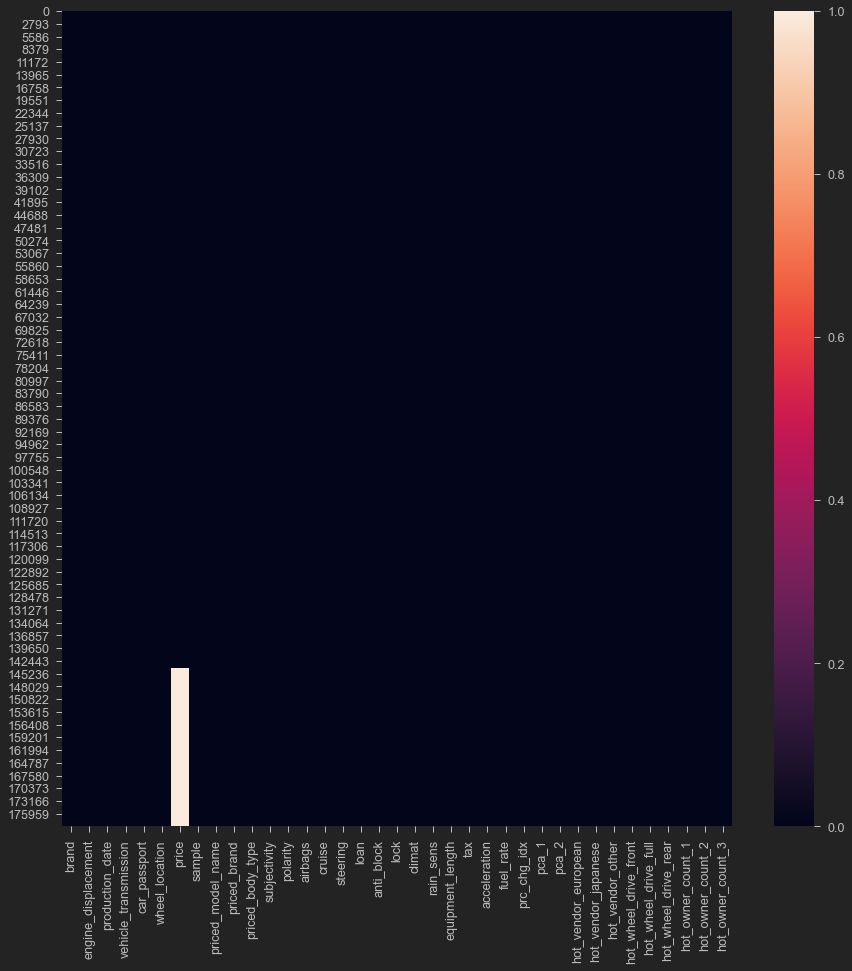

In [172]:
# Plot missing values
cols = df.columns
fig, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(df[cols].isnull()) 

# Show in percents
for col in df.columns:
    pct_missing = np.mean(df[col].isnull())
    print(f'{col} - {round(pct_missing*100,3)}%')

The data set is ready.

<a id="sec6"></a>
# [Prepare the data for models](#sec6)
[(INDEX)](#sec2)

In [245]:
# TEST
df1 = df[(df['brand'] == 'bmw') | (df['brand'] == 'mercedes')]
df2 = df[(df['brand'] != 'bmw') & (df['brand'] != 'mercedes')]
df1 = df1.drop('brand',axis=1)
df2 = df2.drop('brand',axis=1)

In [246]:
# TEST
X1 = df1[df1['sample'] == 1].drop(['price','sample'], axis=1)
y1 = df1[df1['sample'] == 1]['price']

X_test1 = df1[df1['sample'] == 0].drop(['price','sample'], axis=1)
y_test1 = df1[df1['sample'] == 0]['price']


# Defining features and target
X2 = df2[df2['sample'] == 1].drop(['price','sample'], axis=1)
y2 = df2[df2['sample'] == 1]['price']

X_test2 = df2[df2['sample'] == 0].drop(['price','sample'], axis=1)
y_test2 = df2[df2['sample'] == 0]['price']

In [173]:
# Defining features and target
X = df[df['sample'] == 1].drop(['price','sample'], axis=1)
y = df[df['sample'] == 1]['price']

X_test = df[df['sample'] == 0].drop(['price','sample'], axis=1)
y_test = df[df['sample'] == 0]['price']

In [247]:
cols_to_scal = [
    'engine_displacement', 
    'subjectivity', 
    'polarity', 
    'acceleration',
    'fuel_rate', 
    'pca_1', 'pca_2', 
    'equipment_length', 
    'priced_model_name',
    'priced_brand', 
    'priced_body_type', 
    'tax', 
]

In [ ]:
# test

In [248]:
scaler = RobustScaler()
X1[cols_to_scal] = scaler.fit_transform(X1[cols_to_scal])
X_test1[cols_to_scal] = scaler.transform(X_test1[cols_to_scal])

X2[cols_to_scal] = scaler.fit_transform(X2[cols_to_scal])
X_test2[cols_to_scal] = scaler.transform(X_test2[cols_to_scal])

In [175]:
scaler = RobustScaler()
X[cols_to_scal] = scaler.fit_transform(X[cols_to_scal])
X_test[cols_to_scal] = scaler.transform(X_test[cols_to_scal])

In [249]:
# TEST
# Splitting the data
X_train1, X_val1, y_train1, y_val1 = train_test_split(X1,
                                                  y1,
                                                  test_size=0.2,
                                                  shuffle=True,
                                                  random_state=42)

X_train2, X_val2, y_train2, y_val2 = train_test_split(X2,
                                                  y2,
                                                  test_size=0.2,
                                                  shuffle=True,
                                                  random_state=42)



In [176]:
# Splitting the data
X_train, X_val, y_train, y_val = train_test_split(X,
                                                  y,
                                                  test_size=0.2,
                                                  shuffle=True,
                                                  random_state=42)

print(
    f'Train size: {X_train.shape}, Validation size: {X_val.shape}, Test size: {X_test.shape}'
)

Train size: (115236, 35), Validation size: (28810, 35), Test size: (34686, 35)


<a id="sec6"></a>
# [MODELS](#sec6)
[(INDEX)](#sec2)

There are plenty of algorithms could be applied but which one is best, which one is works faster?

Let's try to new instrument, to compare most common algorithms and then select the best.

We will use LazyPredict for such purpose

In [ ]:
lazy = LazyRegressor(verbose=1, ignore_warnings=False, custom_metric=None)
models,predictions = lazy.fit(X_train, X_val, y_train, y_val)
models

We will take the RMSE metric as a starting point.

It is noted, that RandomForest regressor takes first place by giving lowest RMSE value.

Then two booster come: 
    -XGB
    -LGBM
We can see, that the time of computing significantly lower than in RandomForest.
Extra Tree regressor works faster than Random Forest but gives worse RMSE.

We will try to implement some of those algorithms for our dataset.

<a id="sec6"></a>
## [Random Forest](#sec6)
[(INDEX)](#sec2)

We will start with random forest.

Apply the gridsearch for best parameters search

In [125]:
rf_reg = RandomForestRegressor(random_state=42)
param = {
    'bootstrap': [True],
    'max_depth': [10, 30],
    'n_estimators': [100, 200, 300]
}
reg_rf = GridSearchCV(rf_reg, param, scoring='neg_mean_absolute_error',
                      refit=True, cv=5, verbose=0, n_jobs=-1)

In [126]:
reg_rf.fit(X_train, y_train)
print('Best MAE: {:.4}, with best C: {}'.format(reg_rf.best_score_,
                                                reg_rf.best_params_))

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 49.3min finished


GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'bootstrap': [True], 'max_depth': [10, 30],
                         'n_estimators': [300, 600, 1000]},
             scoring='neg_mean_absolute_error', verbose=1)

In [115]:
y_pred_rf = reg_rf.predict(X_val)

In [117]:
df_report = pd.DataFrame(data=None)

In [129]:
df_report = get_regression_metrics(df_report,y_val,y_pred_rf, 'RandomForest')
df_report

,MAPE,MAE,MSE,RMSE
RandomForest,15.57,119448.62,95352149458.24,308791.43


For the first attempt it is not so bad. MAPE is 15.6%

The best score has been obtained with n_estimators = 300.

Let's check another algorithm

<a id="sec6"></a>
## [EXTRA-TREE](#sec6)
[(INDEX)](#sec2)

In [131]:
etr_reg = ExtraTreesRegressor(random_state=42)
param = {
    'bootstrap': [True],
    'max_depth': [10, 30],
    'n_estimators': [100, 200, 300,400]
}
etr_reg_gs = GridSearchCV(etr_reg, param, scoring='neg_mean_absolute_error',
                      refit=True, cv=5, verbose=0, n_jobs=-1,)

In [132]:
etr_reg_gs.fit(X_train, y_train)
print('Best MAE: {:.4}, with best C: {}'.format(etr_reg_gs.best_score_,
                                                etr_reg_gs.best_params_))

Best MAE: -0.1456, with best C: {'bootstrap': True, 'max_depth': 30, 'n_estimators': 100}


In [133]:
y_pred_etr_gs = etr_reg_gs.predict(X_val)

In [134]:
df_report = get_regression_metrics(
    df_report, y_val, y_pred_etr_gs, 'ExtraTree_GS')
df_report

,MAPE,MAE,MSE,RMSE
RandomForest,15.57,119448.62,95352149458.24,308791.43
ExtraTree_GS,15.31,117543.86,92968637935.73,304907.59


In [135]:
# Training and evaluating Extra Tree
etr = ExtraTreesRegressor(n_estimators=300, random_state=42, n_jobs=-1,
                         bootstrap=True, verbose=0)
etr.fit(X_train, y_train)
y_pred_etr = etr.predict(X_val)

NameError: name 'rf' is not defined

In [137]:
df_report = get_regression_metrics(df_report,y_val,y_pred_etr, 'ExtraTree_WO_GS')
df_report

,MAPE,MAE,MSE,RMSE
RandomForest,15.57,119448.62,95352149458.24,308791.43
ExtraTree_GS,15.31,117543.86,92968637935.73,304907.59
ExtraTree_WO_GS,15.26,116998.52,93744649406.88,306177.48


That's a little strange. We specified to minimize MAE in gridsearch for Etxta Tree Regressor, but looking at the output presented in df_report, we see, that if we slelect more estimators than GridSearch suggested, then better score can be obtained. Seems GridSearch minimizer RMSE instead of MAE.

Anyway, Extra Tree Regressor shows better results than Random forest what is contradicts with Lazy Predictor.

In [ ]:
# rf.fit(X, y) # Обучим для сабмита на всей выборке

In [ ]:
sell_id = pd.read_csv('test.csv')['sell_id']

In [ ]:
# submission_tree = pd.DataFrame({'sell_id': sell_id,
#                            'price': np.exp(rf.predict(X_test))*0.905})

In [ ]:
# submission_tree.to_csv('submission_tree.csv', index=False)

<a id="sec6"></a>
## [CAT_boost](#sec6)
[(INDEX)](#sec2)

In [ ]:
# Training the model
cbr = CatBoostRegressor()

# Grid search for catboost model
param_grid = {'iterations': [500],
              'learning_rate': [0.01, 0.1, 0.25, 0.5],
              'l2_leaf_reg': [1, 3, 5, 10],
              'depth': np.arange(10, 14),
              'thread_count': [4]}

cbr.grid_search(param_grid=param_grid,
                X=X,
                y=y,
                cv=5,
                partition_random_seed=42,
                calc_cv_statistics=True,
                search_by_train_test_split=True,
                refit=True,
                shuffle=True,
                stratified=None,
                train_size=0.8,
                verbose=False,
                plot=True)

In [ ]:
cbr.fit(X_train,y_train)

In [ ]:
cbr_pred = cbr.predict(X_val)

In [ ]:
# Best model parameters
cbr.get_params()

In [ ]:
df_report = get_regression_metrics(df_report,y_val,cbr_pred, 'CatBoost')
df_report

In [ ]:
cbr = CatBoostRegressor(loss_function='RMSE',
                        thread_count=4,
                        depth=10,
                        l2_leaf_reg=1,
                        iterations=500,
                        learning_rate=0.1)

cbr.fit(X_train, y_train)

In [ ]:
submission_cat_boost = pd.DataFrame({
    'sell_id':
    sell_id,
    'price':
    np.exp(cbr.predict(X_test)) * 0.905
})

In [ ]:
submission_cat_boost.to_csv('submission_cat_boost.csv', index=False)

# XGBoost

In [ ]:
# Training xgboost model
xg_reg = xgb.XGBRegressor(objective='reg:squarederror', colsample_bytree=0.5,
                          learning_rate=0.05, max_depth=12, alpha=1,
                          n_estimators=1000, silent=1)
xg_reg.fit(X_train, y_train)
xg_red_pred = xg_reg.predict(X_val)

In [ ]:
df_report = get_regression_metrics(df_report,y_val,xg_red_pred, 'XGBoost_1')
df_report

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(15,15))
plot_importance(xg_reg,ax=ax);

In [ ]:
# submission_XGboost = pd.DataFrame({'sell_id': sell_id,
#                            'price': np.exp(xg_reg.predict(X_test))*0.905})

# submission_XGboost.to_csv('submission_XGboost.csv', index=False)

# LGBM

In [250]:
def lgbt(X_train, y_train, X_val, y_val):
    # Defining lightgbm hyper-parameters
    hyper_params = {
        'task': 'train',
        'boosting_type': 'gbdt',
        'objective': 'regression',
        'metric': ['mape'],
        'learning_rate': 0.05,
        'feature_fraction': 0.9,
        'bagging_fraction': 0.7,
        'bagging_freq': 10,
        'verbose': 0,
        "max_depth": 12,
        "num_leaves": 128,
        "max_bin": 512,
        "num_iterations": 1000,
        "n_estimators": 1000
    }
    # Training lightgbm model
    lgbm = lgb.LGBMRegressor(**hyper_params)
    lgbm.fit(X_train, y_train,
             eval_set=[(X_val, y_val)],
             eval_metric='l1',
             early_stopping_rounds=100)
    lgb_pred = lgbm.predict(X_val)
    return lgb_pred

In [253]:
y_pred = lgbt(X_train1,y_train1,X_val1,y_val1)

[1]	valid_0's l1: 1.07519	valid_0's mape: 0.0769835
Training until validation scores don't improve for 100 rounds
[2]	valid_0's l1: 1.02316	valid_0's mape: 0.0732693
[3]	valid_0's l1: 0.973805	valid_0's mape: 0.069746
[4]	valid_0's l1: 0.926917	valid_0's mape: 0.0663979
[5]	valid_0's l1: 0.882678	valid_0's mape: 0.0632402
[6]	valid_0's l1: 0.840614	valid_0's mape: 0.0602367
[7]	valid_0's l1: 0.800991	valid_0's mape: 0.057409
[8]	valid_0's l1: 0.765511	valid_0's mape: 0.0548794
[9]	valid_0's l1: 0.729686	valid_0's mape: 0.0523207
[10]	valid_0's l1: 0.697711	valid_0's mape: 0.0500404
[11]	valid_0's l1: 0.665606	valid_0's mape: 0.0477487
[12]	valid_0's l1: 0.635175	valid_0's mape: 0.0455766
[13]	valid_0's l1: 0.606657	valid_0's mape: 0.0435429
[14]	valid_0's l1: 0.579466	valid_0's mape: 0.0416017
[15]	valid_0's l1: 0.553712	valid_0's mape: 0.0397634
[16]	valid_0's l1: 0.529393	valid_0's mape: 0.038029
[17]	valid_0's l1: 0.506405	valid_0's mape: 0.0363888
[18]	valid_0's l1: 0.484901	valid_

[213]	valid_0's l1: 0.153238	valid_0's mape: 0.0115014
[214]	valid_0's l1: 0.153234	valid_0's mape: 0.0115012
[215]	valid_0's l1: 0.153238	valid_0's mape: 0.0115015
[216]	valid_0's l1: 0.153255	valid_0's mape: 0.011503
[217]	valid_0's l1: 0.153248	valid_0's mape: 0.0115026
[218]	valid_0's l1: 0.153247	valid_0's mape: 0.0115028
[219]	valid_0's l1: 0.153235	valid_0's mape: 0.0115015
[220]	valid_0's l1: 0.153192	valid_0's mape: 0.0114988
[221]	valid_0's l1: 0.153231	valid_0's mape: 0.0115021
[222]	valid_0's l1: 0.153291	valid_0's mape: 0.0115067
[223]	valid_0's l1: 0.153297	valid_0's mape: 0.0115075
[224]	valid_0's l1: 0.153264	valid_0's mape: 0.0115052
[225]	valid_0's l1: 0.153271	valid_0's mape: 0.0115061
[226]	valid_0's l1: 0.153316	valid_0's mape: 0.0115095
[227]	valid_0's l1: 0.153357	valid_0's mape: 0.0115128
[228]	valid_0's l1: 0.153327	valid_0's mape: 0.011511
[229]	valid_0's l1: 0.153327	valid_0's mape: 0.0115109
[230]	valid_0's l1: 0.153351	valid_0's mape: 0.0115128
[231]	valid_

In [254]:
df_report = get_regression_metrics(df_report,y_val1,y_pred, 'Test BMW3')
df_report

,MAPE,MAE,MSE,RMSE
LGB,15.70,133392.89,108904291196.16,330006.50
LGB_1,15.75,135418.87,111588091790.53,334048.04
LGB_2,15.73,136672.30,115253419078.53,339489.94
LGB_3,15.78,133684.43,107261985793.74,327508.76
LGB_4,15.70,133311.73,107025924945.50,327148.17
Test BMW,15.85,272654.09,649000471147.42,805605.65
Test rest,15.36,102232.27,41679412935.60,204155.36
Test BMW2,197.30,2665049.63,17882088335907.81,4228721.83
Test BMW3,16.19,273996.46,658931330250.55,811745.85


In [255]:
y_pred2 = lgbt(X_train2,y_train2,X_val2,y_val2)

[1]	valid_0's l1: 0.841463	valid_0's mape: 0.0639277
Training until validation scores don't improve for 100 rounds
[2]	valid_0's l1: 0.802157	valid_0's mape: 0.0609514
[3]	valid_0's l1: 0.765127	valid_0's mape: 0.0581494
[4]	valid_0's l1: 0.729775	valid_0's mape: 0.0554735
[5]	valid_0's l1: 0.696324	valid_0's mape: 0.0529408
[6]	valid_0's l1: 0.66471	valid_0's mape: 0.0505473
[7]	valid_0's l1: 0.634771	valid_0's mape: 0.0482798
[8]	valid_0's l1: 0.606463	valid_0's mape: 0.0461359
[9]	valid_0's l1: 0.579712	valid_0's mape: 0.0441095
[10]	valid_0's l1: 0.554305	valid_0's mape: 0.0421855
[11]	valid_0's l1: 0.5303	valid_0's mape: 0.0403676
[12]	valid_0's l1: 0.507578	valid_0's mape: 0.0386465
[13]	valid_0's l1: 0.48611	valid_0's mape: 0.0370211
[14]	valid_0's l1: 0.465699	valid_0's mape: 0.035476
[15]	valid_0's l1: 0.446522	valid_0's mape: 0.0340243
[16]	valid_0's l1: 0.428208	valid_0's mape: 0.0326384
[17]	valid_0's l1: 0.41111	valid_0's mape: 0.0313443
[18]	valid_0's l1: 0.394934	valid_0

[153]	valid_0's l1: 0.150856	valid_0's mape: 0.0118286
[154]	valid_0's l1: 0.150817	valid_0's mape: 0.0118257
[155]	valid_0's l1: 0.150749	valid_0's mape: 0.0118205
[156]	valid_0's l1: 0.150684	valid_0's mape: 0.0118155
[157]	valid_0's l1: 0.150666	valid_0's mape: 0.0118144
[158]	valid_0's l1: 0.150626	valid_0's mape: 0.0118115
[159]	valid_0's l1: 0.150585	valid_0's mape: 0.0118084
[160]	valid_0's l1: 0.150523	valid_0's mape: 0.0118038
[161]	valid_0's l1: 0.150457	valid_0's mape: 0.011799
[162]	valid_0's l1: 0.150374	valid_0's mape: 0.011793
[163]	valid_0's l1: 0.150299	valid_0's mape: 0.0117873
[164]	valid_0's l1: 0.150261	valid_0's mape: 0.0117847
[165]	valid_0's l1: 0.150205	valid_0's mape: 0.0117806
[166]	valid_0's l1: 0.150116	valid_0's mape: 0.0117739
[167]	valid_0's l1: 0.150099	valid_0's mape: 0.0117726
[168]	valid_0's l1: 0.150059	valid_0's mape: 0.0117697
[169]	valid_0's l1: 0.150048	valid_0's mape: 0.011769
[170]	valid_0's l1: 0.150014	valid_0's mape: 0.0117664
[171]	valid_0

[330]	valid_0's l1: 0.146854	valid_0's mape: 0.0115461
[331]	valid_0's l1: 0.146847	valid_0's mape: 0.0115457
[332]	valid_0's l1: 0.146849	valid_0's mape: 0.011546
[333]	valid_0's l1: 0.146866	valid_0's mape: 0.0115473
[334]	valid_0's l1: 0.146874	valid_0's mape: 0.0115481
[335]	valid_0's l1: 0.146855	valid_0's mape: 0.0115467
[336]	valid_0's l1: 0.146872	valid_0's mape: 0.0115481
[337]	valid_0's l1: 0.146873	valid_0's mape: 0.0115482
[338]	valid_0's l1: 0.146852	valid_0's mape: 0.0115467
[339]	valid_0's l1: 0.146849	valid_0's mape: 0.0115465
[340]	valid_0's l1: 0.146849	valid_0's mape: 0.0115465
[341]	valid_0's l1: 0.146852	valid_0's mape: 0.0115467
[342]	valid_0's l1: 0.146858	valid_0's mape: 0.0115472
[343]	valid_0's l1: 0.146859	valid_0's mape: 0.0115472
[344]	valid_0's l1: 0.146864	valid_0's mape: 0.0115476
[345]	valid_0's l1: 0.14686	valid_0's mape: 0.0115474
[346]	valid_0's l1: 0.146855	valid_0's mape: 0.011547
[347]	valid_0's l1: 0.146868	valid_0's mape: 0.0115481
[348]	valid_0

[495]	valid_0's l1: 0.146387	valid_0's mape: 0.011521
[496]	valid_0's l1: 0.146374	valid_0's mape: 0.01152
[497]	valid_0's l1: 0.14633	valid_0's mape: 0.0115169
[498]	valid_0's l1: 0.146326	valid_0's mape: 0.0115168
[499]	valid_0's l1: 0.146313	valid_0's mape: 0.0115157
[500]	valid_0's l1: 0.146306	valid_0's mape: 0.0115152
[501]	valid_0's l1: 0.146295	valid_0's mape: 0.0115146
[502]	valid_0's l1: 0.146287	valid_0's mape: 0.011514
[503]	valid_0's l1: 0.146277	valid_0's mape: 0.0115133
[504]	valid_0's l1: 0.146263	valid_0's mape: 0.0115122
[505]	valid_0's l1: 0.146251	valid_0's mape: 0.0115114
[506]	valid_0's l1: 0.146264	valid_0's mape: 0.0115125
[507]	valid_0's l1: 0.146256	valid_0's mape: 0.0115118
[508]	valid_0's l1: 0.146256	valid_0's mape: 0.0115119
[509]	valid_0's l1: 0.14624	valid_0's mape: 0.0115106
[510]	valid_0's l1: 0.146251	valid_0's mape: 0.0115116
[511]	valid_0's l1: 0.146244	valid_0's mape: 0.0115111
[512]	valid_0's l1: 0.146236	valid_0's mape: 0.0115105
[513]	valid_0's 

[655]	valid_0's l1: 0.14547	valid_0's mape: 0.0114569
[656]	valid_0's l1: 0.145476	valid_0's mape: 0.0114573
[657]	valid_0's l1: 0.145479	valid_0's mape: 0.0114576
[658]	valid_0's l1: 0.145474	valid_0's mape: 0.0114573
[659]	valid_0's l1: 0.145489	valid_0's mape: 0.0114585
[660]	valid_0's l1: 0.145497	valid_0's mape: 0.0114592
[661]	valid_0's l1: 0.145491	valid_0's mape: 0.0114587
[662]	valid_0's l1: 0.145484	valid_0's mape: 0.0114582
[663]	valid_0's l1: 0.145487	valid_0's mape: 0.0114584
[664]	valid_0's l1: 0.145476	valid_0's mape: 0.0114575
[665]	valid_0's l1: 0.145465	valid_0's mape: 0.0114566
[666]	valid_0's l1: 0.145465	valid_0's mape: 0.0114567
[667]	valid_0's l1: 0.145473	valid_0's mape: 0.0114574
[668]	valid_0's l1: 0.145482	valid_0's mape: 0.0114581
[669]	valid_0's l1: 0.14549	valid_0's mape: 0.0114589
[670]	valid_0's l1: 0.145484	valid_0's mape: 0.0114584
[671]	valid_0's l1: 0.145494	valid_0's mape: 0.0114592
[672]	valid_0's l1: 0.145509	valid_0's mape: 0.0114603
[673]	valid_

[811]	valid_0's l1: 0.145356	valid_0's mape: 0.0114541
[812]	valid_0's l1: 0.145364	valid_0's mape: 0.0114548
[813]	valid_0's l1: 0.145358	valid_0's mape: 0.0114544
[814]	valid_0's l1: 0.145361	valid_0's mape: 0.0114546
[815]	valid_0's l1: 0.145369	valid_0's mape: 0.0114555
[816]	valid_0's l1: 0.145384	valid_0's mape: 0.0114566
[817]	valid_0's l1: 0.145393	valid_0's mape: 0.0114574
[818]	valid_0's l1: 0.145402	valid_0's mape: 0.0114581
[819]	valid_0's l1: 0.145398	valid_0's mape: 0.0114579
[820]	valid_0's l1: 0.14541	valid_0's mape: 0.0114588
[821]	valid_0's l1: 0.145415	valid_0's mape: 0.0114592
[822]	valid_0's l1: 0.145423	valid_0's mape: 0.0114598
[823]	valid_0's l1: 0.145427	valid_0's mape: 0.0114602
[824]	valid_0's l1: 0.145429	valid_0's mape: 0.0114604
[825]	valid_0's l1: 0.145436	valid_0's mape: 0.011461
[826]	valid_0's l1: 0.145441	valid_0's mape: 0.0114615
[827]	valid_0's l1: 0.145448	valid_0's mape: 0.011462
[828]	valid_0's l1: 0.145451	valid_0's mape: 0.0114623
[829]	valid_0

In [256]:
df_report = get_regression_metrics(df_report,y_val2,y_pred2, 'Test rest')
df_report

,MAPE,MAE,MSE,RMSE
LGB,15.70,133392.89,108904291196.16,330006.50
LGB_1,15.75,135418.87,111588091790.53,334048.04
LGB_2,15.73,136672.30,115253419078.53,339489.94
LGB_3,15.78,133684.43,107261985793.74,327508.76
LGB_4,15.70,133311.73,107025924945.50,327148.17
Test BMW,15.85,272654.09,649000471147.42,805605.65
Test rest,15.36,102232.27,41679412935.60,204155.36
Test BMW2,197.30,2665049.63,17882088335907.81,4228721.83
Test BMW3,16.19,273996.46,658931330250.55,811745.85
Test rest,15.56,101053.71,40426789840.66,201064.14


In [177]:
# Defining lightgbm hyper-parameters
hyper_params = {
                'task': 'train',
                'boosting_type': 'gbdt',
                'objective': 'regression',
                'metric': ['mape'],
                'learning_rate': 0.05,
                'feature_fraction': 0.9,
                'bagging_fraction': 0.7,
                'bagging_freq': 10,
                'verbose': 0,
                "max_depth": 12,
                "num_leaves": 128,  
                "max_bin": 512,
                "num_iterations": 1000,
                "n_estimators": 1000
            }

# Training lightgbm model
lgbm = lgb.LGBMRegressor(**hyper_params)
lgbm.fit(X_train, y_train,
         eval_set=[(X_val, y_val)],
         eval_metric='l1',
         early_stopping_rounds=100)

ValueError: DataFrame.dtypes for data must be int, float or bool.
Did not expect the data types in the following fields: brand

In [166]:
lgb_pred = lgbm.predict(X_val)

In [167]:
df_report = get_regression_metrics(df_report,y_val,lgb_pred, 'LGB_4')
df_report

,MAPE,MAE,MSE,RMSE
LGB,15.70,133392.89,108904291196.16,330006.50
LGB_1,15.75,135418.87,111588091790.53,334048.04
LGB_2,15.73,136672.30,115253419078.53,339489.94
LGB_3,15.78,133684.43,107261985793.74,327508.76
LGB_4,15.70,133311.73,107025924945.50,327148.17


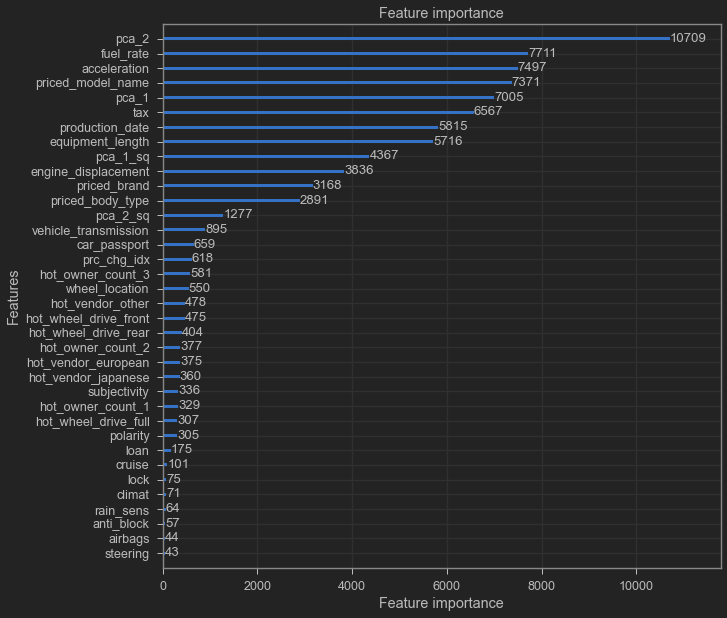

In [168]:
# Check permutation
lightgbm.plot_importance(lgbm, ax=None, height=0.2, xlim=None, ylim=None,
                         title='Feature importance', xlabel='Feature importance', 
                         ylabel='Features', importance_type='split', max_num_features=None,
                         ignore_zero=True, figsize=(10,10), dpi=None, grid=True, precision=3);

# LGBM Optuna

In [ ]:
# Defining MAPE function since it was removed from sklearn
def mape_11(y_pred,y_true): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true) * 100)

In [ ]:
def objective(trial,data=X,target=y):
    
    train_x, test_x, train_y, test_y = train_test_split(data, target, test_size=0.2,random_state=42)
    param = {
        'metric': 'mape', 
        'random_state': 42,
        'n_estimators': trial.suggest_categorical('n_estimators', [50, 100,500,700]),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.006,0.008,0.01,0.014,0.017,0.02]),
        'max_depth': trial.suggest_categorical('max_depth', [10,20,100]),
        'num_leaves' : trial.suggest_int('num_leaves', 1, 1000),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 300),
        'cat_smooth' : trial.suggest_int('min_data_per_groups', 1, 100)
    }
    model = lgb.LGBMRegressor(**param)  
    
    model.fit(train_x,train_y,eval_set=[(test_x,test_y)],early_stopping_rounds=100,verbose=False)
    
    preds = model.predict(test_x)
    
    mape = mape_11(np.expm1(test_y), np.expm1(preds))
    
    return mape

In [ ]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

In [ ]:
# plot_optimization_histor: shows the scores from all trials as 
# well as the best score so far at each point.
optuna.visualization.plot_optimization_history(study)

In [ ]:
#plot_parallel_coordinate: interactively visualizes the hyperparameters and scores
optuna.visualization.plot_parallel_coordinate(study)

In [ ]:
'''plot_slice: shows the evolution of the search. You can see where in the hyperparameter space your search
went and which parts of the space were explored more.'''
optuna.visualization.plot_slice(study)

In [ ]:
#Visualize parameter importances.
optuna.visualization.plot_param_importances(study)

In [ ]:
#Visualize empirical distribution function
optuna.visualization.plot_edf(study)

In [ ]:
param_lgb = study.best_params

In [ ]:
lgb_opt = lgb.LGBMRegressor(**param_lgb)
lgb_opt.fit(X_train, y_train,)
#          eval_set=[(X_val, y_val)],
#          eval_metric='l1',
#          early_stopping_rounds=100)


In [ ]:
lgb_opt_pred = lgb_opt.predict(X_val)

In [ ]:
df_report = get_regression_metrics(df_report,y_val,lgb_opt_pred, 'LGB+optuna')
df_report

## Gradient boost

In [ ]:
params = {'n_estimators': 800,
          'max_depth': 8,
          'min_samples_split': 7,
          'learning_rate': 0.01,
          'loss': 'ls'}

In [ ]:
gboost = GradientBoostingRegressor(**params)
gboost.fit(X_train, y_train)
gboost_pred = gboost.predict(X_val)

In [ ]:
df_report = get_regression_metrics(df_report,y_val,gboost_pred, 'GBOOST')
df_report

In [ ]:
test_score = np.zeros((params['n_estimators'],), dtype=np.float64)
for i, gboost_pred in enumerate(gboost.staged_predict(X_val)):
    test_score[i] = gboost.loss_(y_val, gboost_pred)

fig = plt.figure(figsize=(6, 6))
plt.subplot(1, 1, 1)
plt.title('Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, gboost.train_score_, 'b-',
         label='Training Set Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-',
         label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')
fig.tight_layout()
plt.show()

In [ ]:
gboost.fit(X_train, y_train)

In [ ]:
submission_gboost = pd.DataFrame({'sell_id': sell_id,
                           'price': np.exp(gboost.predict(X_test))*0.905})

submission_gboost.to_csv('submission_gboost.csv', index=False)

## STACKING

In [ ]:
from mlxtend.regressor import StackingRegressor

In [ ]:
ENet = ElasticNet()

In [ ]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()

In [ ]:
stck_regrs = StackingRegressor(regressors=[rf,cbr,xg_reg,lgbm,gboost],
                               meta_regressor=lr)

In [ ]:
stck_regrs.fit(X_train,y_train)

In [ ]:
y_pred_stck_regrs = stck_regrs.predict(X_val)

In [ ]:
df_report = get_regression_metrics(df_report,y_val,y_pred_stck_regrs, 'Stack')
df_report

In [ ]:
extra_pred = rf.predict(X_test)
cbr_pred = cbr.predict(X_test)
xgboost_pred = xg_reg.predict(X_test)
lgb_opt_pred = lgb_opt.predict(X_test)
# lgb_pred = lgbm.predict(X_test)
# gboost = gboost.predict(X_test)
# stck = stck_regrs.predict(X_test)

In [ ]:
df_report

In [ ]:
ensemble = (xgboost_pred*.1 + extra_pred*.1 + cbr_pred*.1 + lgb_opt_pred* .7)

In [ ]:
# #Submission
# stck_regrs = StackingRegressor(regressors=[lgbm, xg_reg, rf,cbr],
#                                meta_regressor=lr)
# stck_regrs.fit(X,y)

In [ ]:
submission_stack = pd.DataFrame({'sell_id': sell_id,
                           'price': np.exp(ensemble)*.92})

submission_stack.to_csv('submission_stack.csv', index=False)

In [139]:
import pwlf